# *Fine-Tuning* do Modelo Final

## Carregando os dados

## Carregando o modelo

## Otimização Bayesiana

In [ ]:
def lgbm_objective(trial):
    n_estimators= trial.suggest_int('n_estimators', 100, 1000, step=100)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    subsample = trial.suggest_float('subsample', 0.5, 1, step=0.1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    
    avg_roc = 0
    avg_acc = 0
    avg_f1 = 0

    n_splits = 5

    kf = StratifiedKFold(
        n_splits=n_splits, 
        shuffle=True, 
        random_state=42
    )

    for tr, ts in kf.split(X_train, Y_train):
        Xtr, Xvl = X_train[tr], X_train[ts]
        ytr, yvl = Y_train[tr], Y_train[ts]

        model = LGBMClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            min_child_weight=min_child_weight,
            random_state=0,
            n_jobs=-1
        )

        model.fit(Xtr, ytr)
        y_pred = model.predict_proba(Xvl)[:, 1]
        y_pred = np.where(y_pred > .4, 1, 0)
        
        avg_roc += roc_auc_score(yvl, y_pred)
        avg_f1 += f1_score(yvl, y_pred, average='weighted')
        avg_acc += accuracy_score(yvl, y_pred)

    print('avg roc =', avg_roc / n_splits)
    print('avg acc =', avg_acc / n_splits)
    print('avg f1 =', avg_f1 / n_splits, end='\n\n')
    
    return avg_f1 / n_splits

study = opt.create_study(direction='maximize')
study.optimize(lgbm_objective, n_trials=20)

lgbm_best_params = study.best_params
lgbm_best_params

## Ajuste de *threshold*

## Testando os modelos

In [ ]:
X_test = df_test.drop('Fraude', axis=1).values
y_test = df_test['Fraude'].values

In [ ]:
model = XGBClassifier(random_state=random_state)
model.fit(X, y)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

In [ ]:
from scikitplot.metrics import plot_confusion_matrix, plot_roc

In [ ]:
y_pred_thresh = np.where(y_proba[:,1] >= 7.9591686e-05, 1, 0)

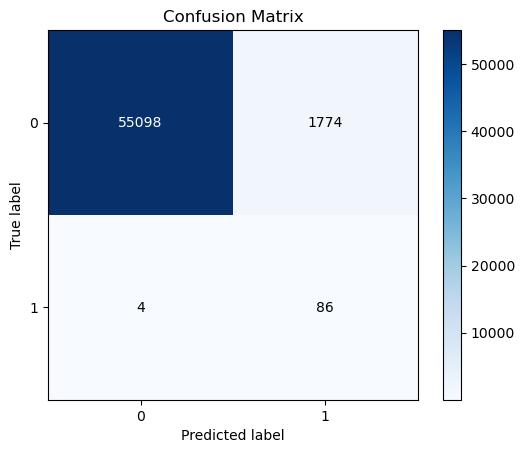

In [ ]:
plot_confusion_matrix(y_test, y_pred_thresh);

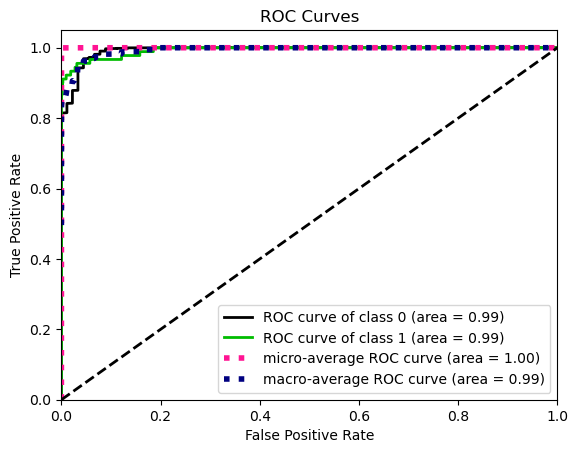

In [ ]:
plot_roc(y_test, y_proba);

In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:,1])

In [ ]:
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

7.9591686e-05

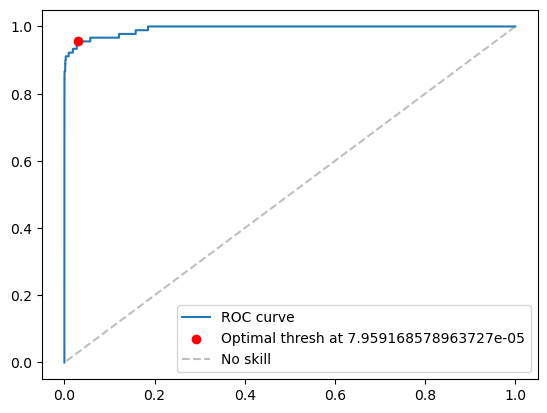

In [ ]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label='ROC curve');

plt.scatter(
    fpr[optimal_idx],
    tpr[optimal_idx],
    color='r',
    zorder=2,
    label=f'Optimal thresh at {optimal_threshold}'
);

plt.plot(
    [1,0], [1,0],
    linestyle='--',
    color='gray',
    alpha=.5,
    label='No skill'
);

plt.legend();